In [ ]:
!pip install minisom matplotlib

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.2-py3-none-any.whl size=10650 sha256=3f7743aa2e3e3585a6848d3426a031c39685d4c9eeda9498da6993ff836e8f8a
  Stored in directory: /root/.cache/pip/wheels/b4/f6/8a/9daf8831901c3e3805775633404248f10663d1c80b7e5a1314
Successfully built minisom


In [ ]:
from IPython import display

import numpy as np
from minisom import MiniSom
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

# Download MNIST dataset
X_mnist, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
# Normalize data
X_mnist = X_mnist / 255.0



/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
X_mnist = X_mnist[y == '1']
X_mnist.shape

(7877, 784)

# miniSOM

In [ ]:
def plot_som_centroids(som, som_size):
    # Plot the weights of the Kohonen map
    plt.figure(figsize=(som_size, som_size))
    for i in range(som_size):
        for j in range(som_size):
            weight = som.get_weights()[i, j].reshape(28, 28)  # Reshape weights to 28x28 (MNIST images size)
            plt.subplot(som_size, som_size, i*som_size+j+1)
            plt.imshow(weight, cmap='gray')
            plt.axis('off')
    plt.show()

In [ ]:
# Initialize Kohonen map (SOM)
som_size = 20  # 10x10 grid
som = MiniSom(som_size, som_size, X_mnist.shape[1], sigma=1.0, learning_rate=0.5)

# Train SOM

In [ ]:
print("Training Kohonen map...")

for epoch in range(10):
    print(f"Epoch {epoch+1}/10, Quantization error:, {som.quantization_error(X_mnist)}", end=" ")

    som.train_random(X_mnist, X_mnist.shape[0])  # Train with 60000 iterations
    print()

print("Training completed.")

Training Kohonen map...
Epoch 1/10, Quantization error:, 7.050060220999688 
Epoch 2/10, Quantization error:, 2.0787256887248495 
Epoch 3/10, Quantization error:, 2.0199663446971 
Epoch 4/10, Quantization error:, 1.9818146362682072 
Epoch 5/10, Quantization error:, 1.9605778351920244 
Epoch 6/10, Quantization error:, 1.9392190353677912 
Epoch 7/10, Quantization error:, 1.9412036485652602 
Epoch 8/10, Quantization error:, 1.9362134151668555 
Epoch 9/10, Quantization error:, 1.9375455371446193 
Epoch 10/10, Quantization error:, 1.933548296060644 
Training completed.


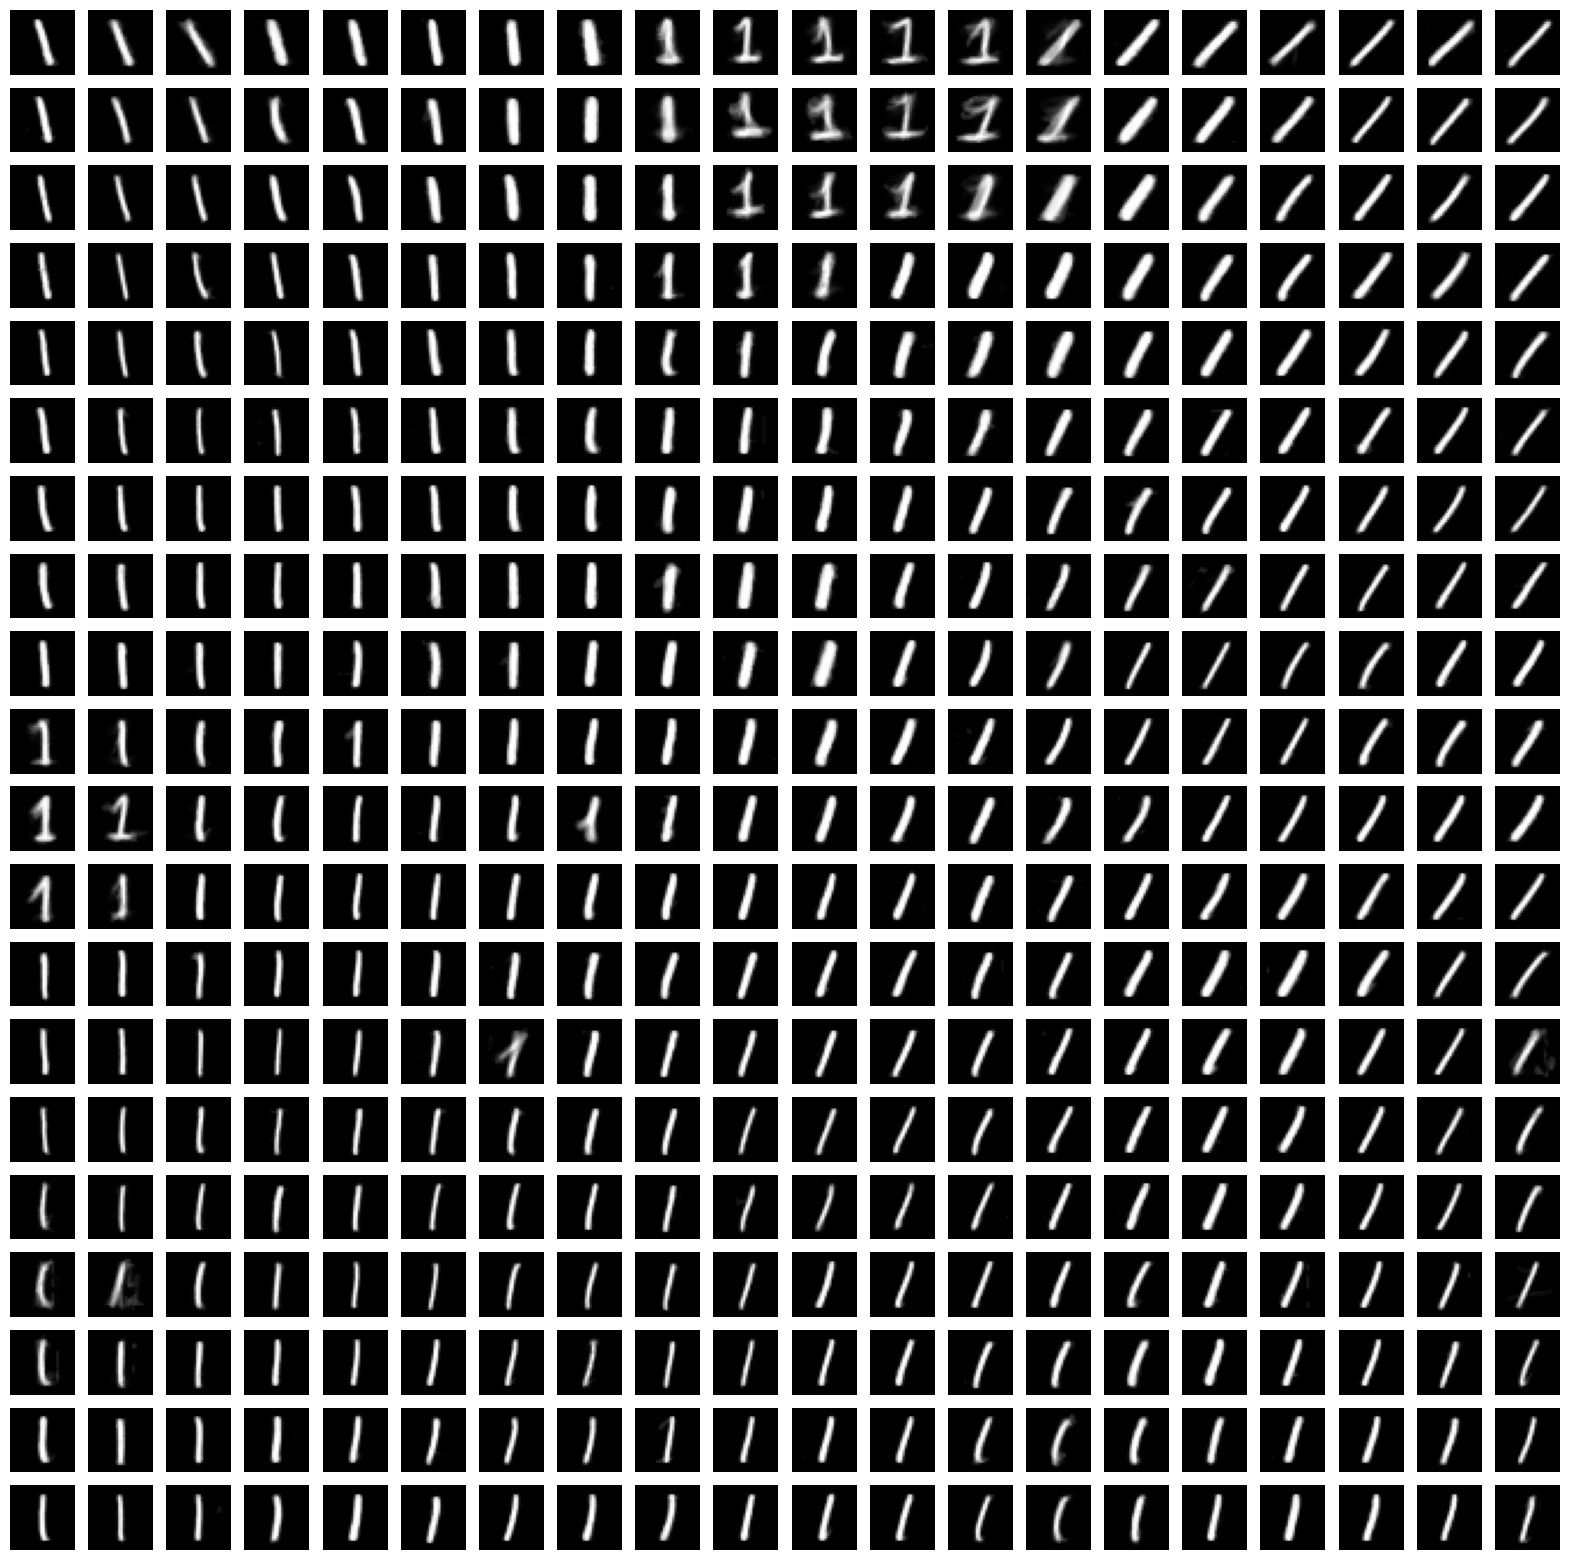

In [ ]:
plot_som_centroids(som, som_size)


# learning inverse function

In [ ]:
from sklearn.neighbors import NearestNeighbors

def round_centroids(som, som_size, X_mnist):
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(X_mnist)

    round_centroids = np.zeros((som_size, som_size, 28, 28))
    for i in range(som_size):
        for j in range(som_size):
            centroid = som.get_weights()[i, j].reshape(1, -1)
            _, idx = nn.kneighbors(centroid, 1)

            round_centroids[i,j] = X_mnist[idx,:].reshape(28,28)
    return round_centroids

rounded_centroids = round_centroids(som, som_size, X_mnist)

Poniżej: $X \in \mathbb{R}^2$, natomiast $Y\in \mathbb{R}^{784}$. $x_i$ to pozycja $i$-tego centroidu w topologii mapy Kohonena, natomiast $y_i$ to nie jest sama surowa pozycja tego centroidu w $\mathbb{R}^{784}$, tylko $y_i$ to jest najbliższy centroidowi prawdziwy obrazek. Dzięki temu model uczy się na obrazkach z ostrzejszym detalem.

In [ ]:
X = np.zeros((som_size**2, 2))
Y = np.zeros((som_size**2, 784))

for i in range(som_size):
    for j in range(som_size):
        X[i*som_size+j,:] = np.array([i, j])
        Y[i*som_size+j,:] = rounded_centroids[i,j].reshape(1, -1)

In [ ]:
!pip install xgboost

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

model = make_pipeline(PolynomialFeatures(2), XGBRegressor())
model.fit(X, Y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
X

array([[ 0.,  0.],
       [ 0.,  1.],
       [ 0.,  2.],
       [ 0.,  3.],
       [ 0.,  4.],
       [ 0.,  5.],
       [ 0.,  6.],
       [ 0.,  7.],
       [ 0.,  8.],
       [ 0.,  9.],
       [ 0., 10.],
       [ 0., 11.],
       [ 0., 12.],
       [ 0., 13.],
       [ 0., 14.],
       [ 0., 15.],
       [ 0., 16.],
       [ 0., 17.],
       [ 0., 18.],
       [ 0., 19.],
       [ 1.,  0.],
       [ 1.,  1.],
       [ 1.,  2.],
       [ 1.,  3.],
       [ 1.,  4.],
       [ 1.,  5.],
       [ 1.,  6.],
       [ 1.,  7.],
       [ 1.,  8.],
       [ 1.,  9.],
       [ 1., 10.],
       [ 1., 11.],
       [ 1., 12.],
       [ 1., 13.],
       [ 1., 14.],
       [ 1., 15.],
       [ 1., 16.],
       [ 1., 17.],
       [ 1., 18.],
       [ 1., 19.],
       [ 2.,  0.],
       [ 2.,  1.],
       [ 2.,  2.],
       [ 2.,  3.],
       [ 2.,  4.],
       [ 2.,  5.],
       [ 2.,  6.],
       [ 2.,  7.],
       [ 2.,  8.],
       [ 2.,  9.],
       [ 2., 10.],
       [ 2., 11.],
       [ 2.,

In [ ]:
def plot_generation(model, rounded_centroids):
    som_size = rounded_centroids.shape[0]
    plt.figure(figsize=(som_size, som_size))
    for i in range(som_size):
        for j in range(som_size):
            x = np.array([[i, j]]) + np.random.uniform(low=-0.5, high=0.5, size=(2))
            plt.subplot(som_size, som_size, i*som_size+j+1)
            plt.imshow(model.predict(x).reshape(28,28), cmap='gray')
            plt.axis('off')
    plt.show()

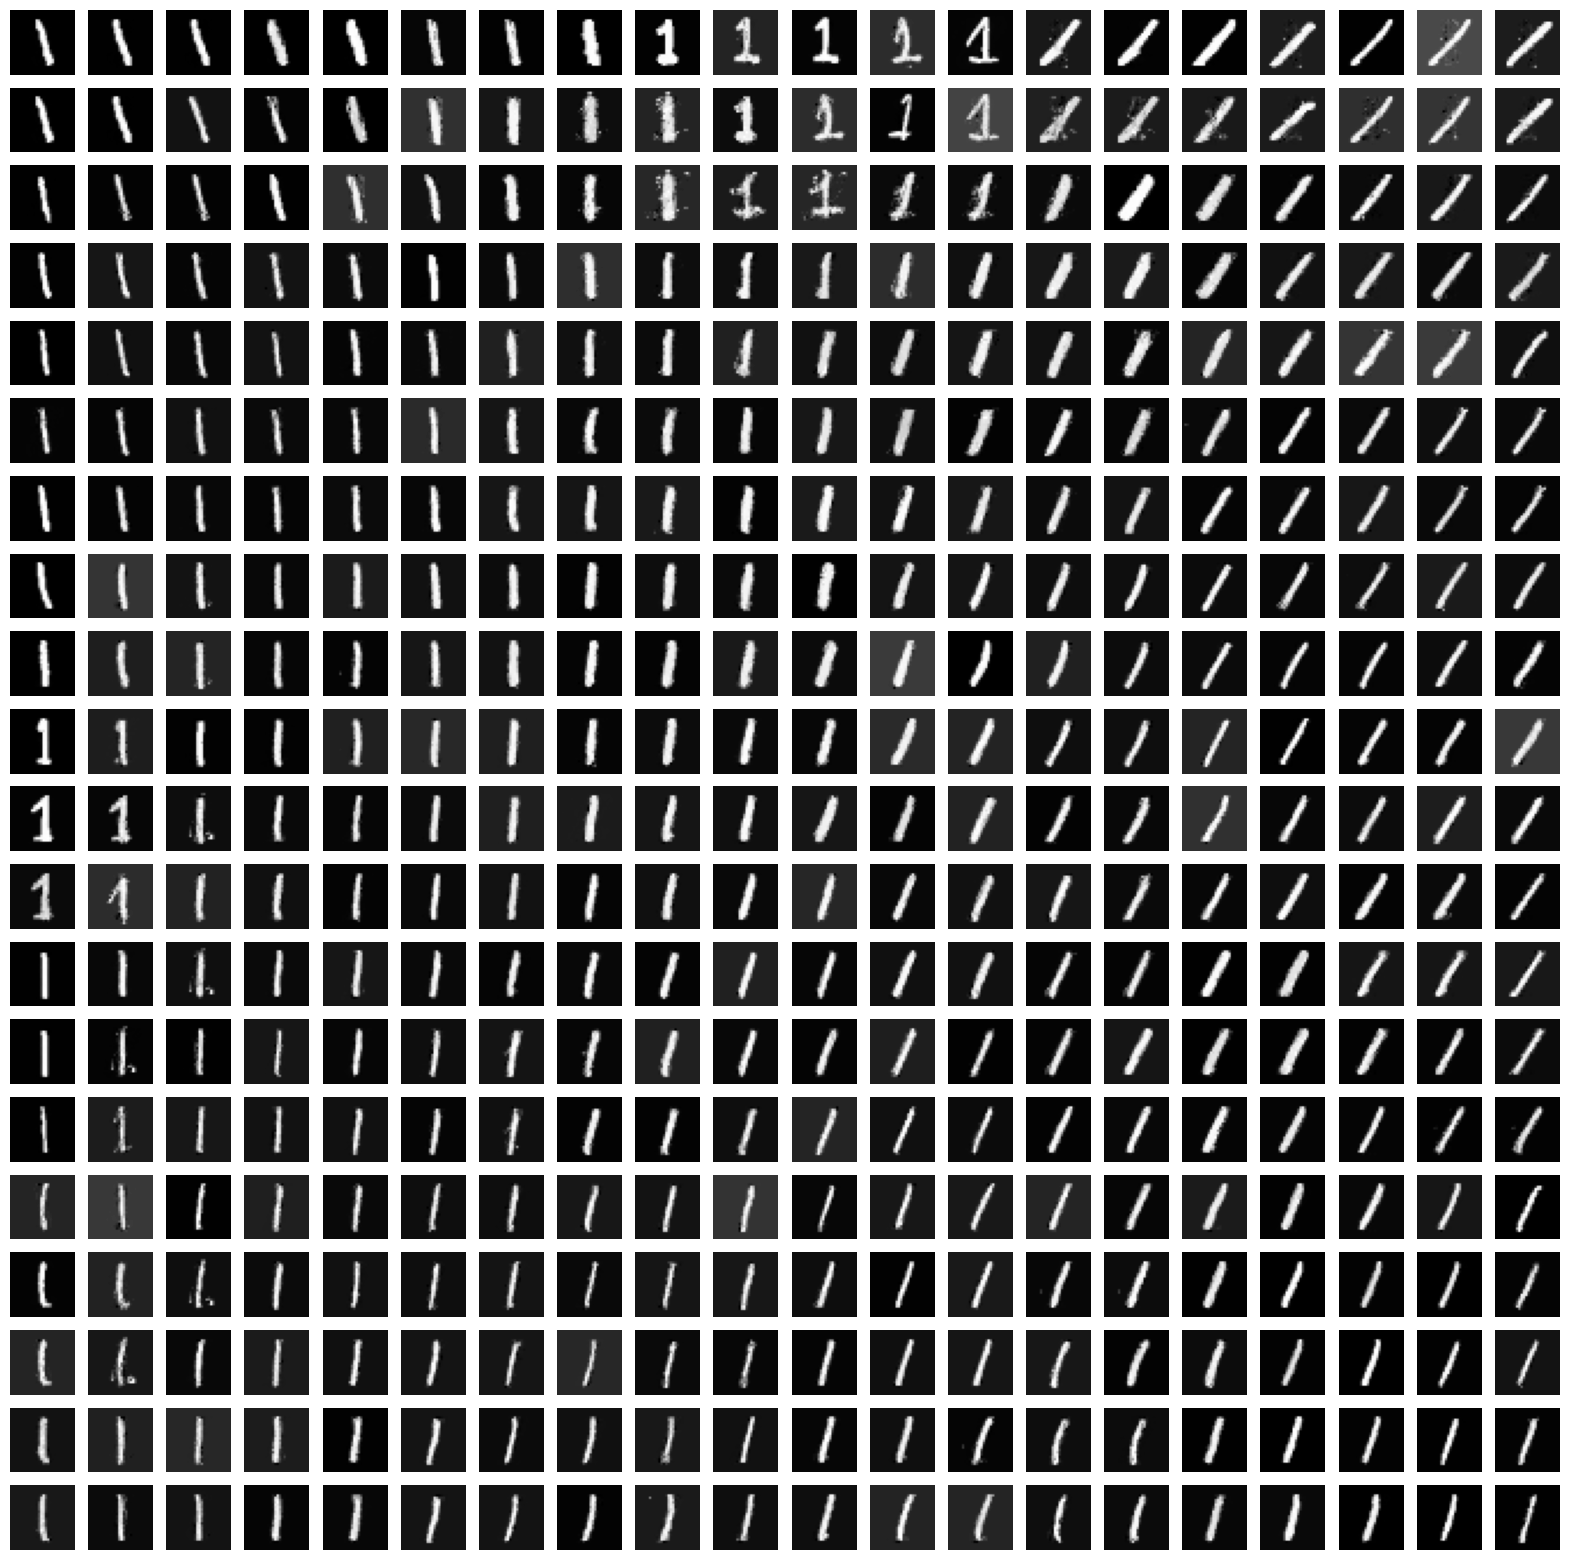

In [ ]:
plot_generation(model, rounded_centroids)

# jak ocenić jakość generacji?

Użyjmy kolejnego klasyfikatora do oceny jakości generowania. Stwórzmy dataset złożony z oryginalnych obrazków i złożony z takiej samej ilości obrazków wygenerowanych przez nas. Labele y mówią 1, gdy prawdziwy, a 0, gdy fejk.
Intuicja:
- jeśli obrazki są słabe, to k-NN będzie miał 100% accuracy przy klasyfikacji
- jeśli obrazki są idealnie wierne oryginałom, to accuracy będzie bardzo niskie

Zadanie do pomyślenia:
- **czy w ogóle możliwe jest, aby 1-NN klasyfikator mógł mieć kiedykolwiek 0% accuracy? co dla 2-NN?**

In [ ]:
X_tru = Y
X_tru.shape

(400, 784)

In [ ]:
data_uniform = np.random.uniform(0, 19, (X_tru.shape[0], 2))
data_uniform

array([[1.66224945e+01, 1.08566263e+01],
       [1.20797806e+01, 8.67795758e+00],
       [8.46201053e+00, 7.01993192e+00],
       [1.06754738e+01, 1.75680633e+01],
       [1.10718897e+01, 1.08517450e+01],
       [1.74440765e+01, 2.44550647e+00],
       [1.02194860e+00, 1.74814233e+01],
       [9.56865008e+00, 1.11167116e+00],
       [1.69667807e+01, 1.36085236e+01],
       [1.88981671e+01, 1.31557804e+00],
       [1.31034580e+01, 4.62398058e+00],
       [1.34598114e+01, 7.48537813e-01],
       [1.14386533e+01, 1.91927317e-01],
       [1.46636285e+00, 8.73090528e+00],
       [1.82942909e+01, 2.63486451e+00],
       [5.26711488e+00, 1.67710529e+00],
       [5.89666561e+00, 4.15293114e+00],
       [1.46883425e+01, 1.78400334e+00],
       [7.88184269e+00, 1.42682237e+01],
       [7.30933254e+00, 1.84569926e+01],
       [1.42951905e+01, 9.06852720e-01],
       [7.82439444e+00, 1.98247735e+00],
       [9.16515182e+00, 4.96554017e+00],
       [1.13761138e+01, 4.64901285e+00],
       [1.583962

In [ ]:
data_uniform.shape

(400, 2)

In [ ]:
generated_images = []
for i, random_point in enumerate(data_uniform):
    generated_images.append(model.predict(random_point.reshape(1, -1)).reshape(-1))

X_gen = np.array(generated_images)

In [ ]:
X_gen.shape

(400, 784)

In [ ]:
X = np.vstack([X_tru, X_gen])
y = np.array(X_tru.shape[0]*[1] + X_gen.shape[0]*[0])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create kNN classifier. You can adjust the number of neighbors (n_neighbors)
knn = KNeighborsClassifier(n_neighbors=4)

# Train the classifier
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 52.92%


In [ ]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define the number of folds for cross-validation
n_splits = 12
# Initialize the K-Fold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store accuracy scores for each fold
accuracy_scores = []

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(X):
    # Split the dataset into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create kNN classifier with desired parameters
    knn = KNeighborsClassifier(n_neighbors=3)

    # Train the classifier
    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test)

    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(fold_accuracy)

# Calculate the average accuracy across all folds
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Average Accuracy: {average_accuracy * 100:.2f}%")


Average Accuracy: 42.62%


In [ ]:
def plot_generated_images(generated_images):
    plt.figure(figsize=(som_size, som_size))
    for i in range(som_size):
        for j in range(som_size):
            plt.subplot(som_size, som_size, i*som_size+j+1)
            plt.imshow(generated_images[i*som_size + j].reshape(28,28), cmap='gray')
            plt.axis('off')
    plt.show()

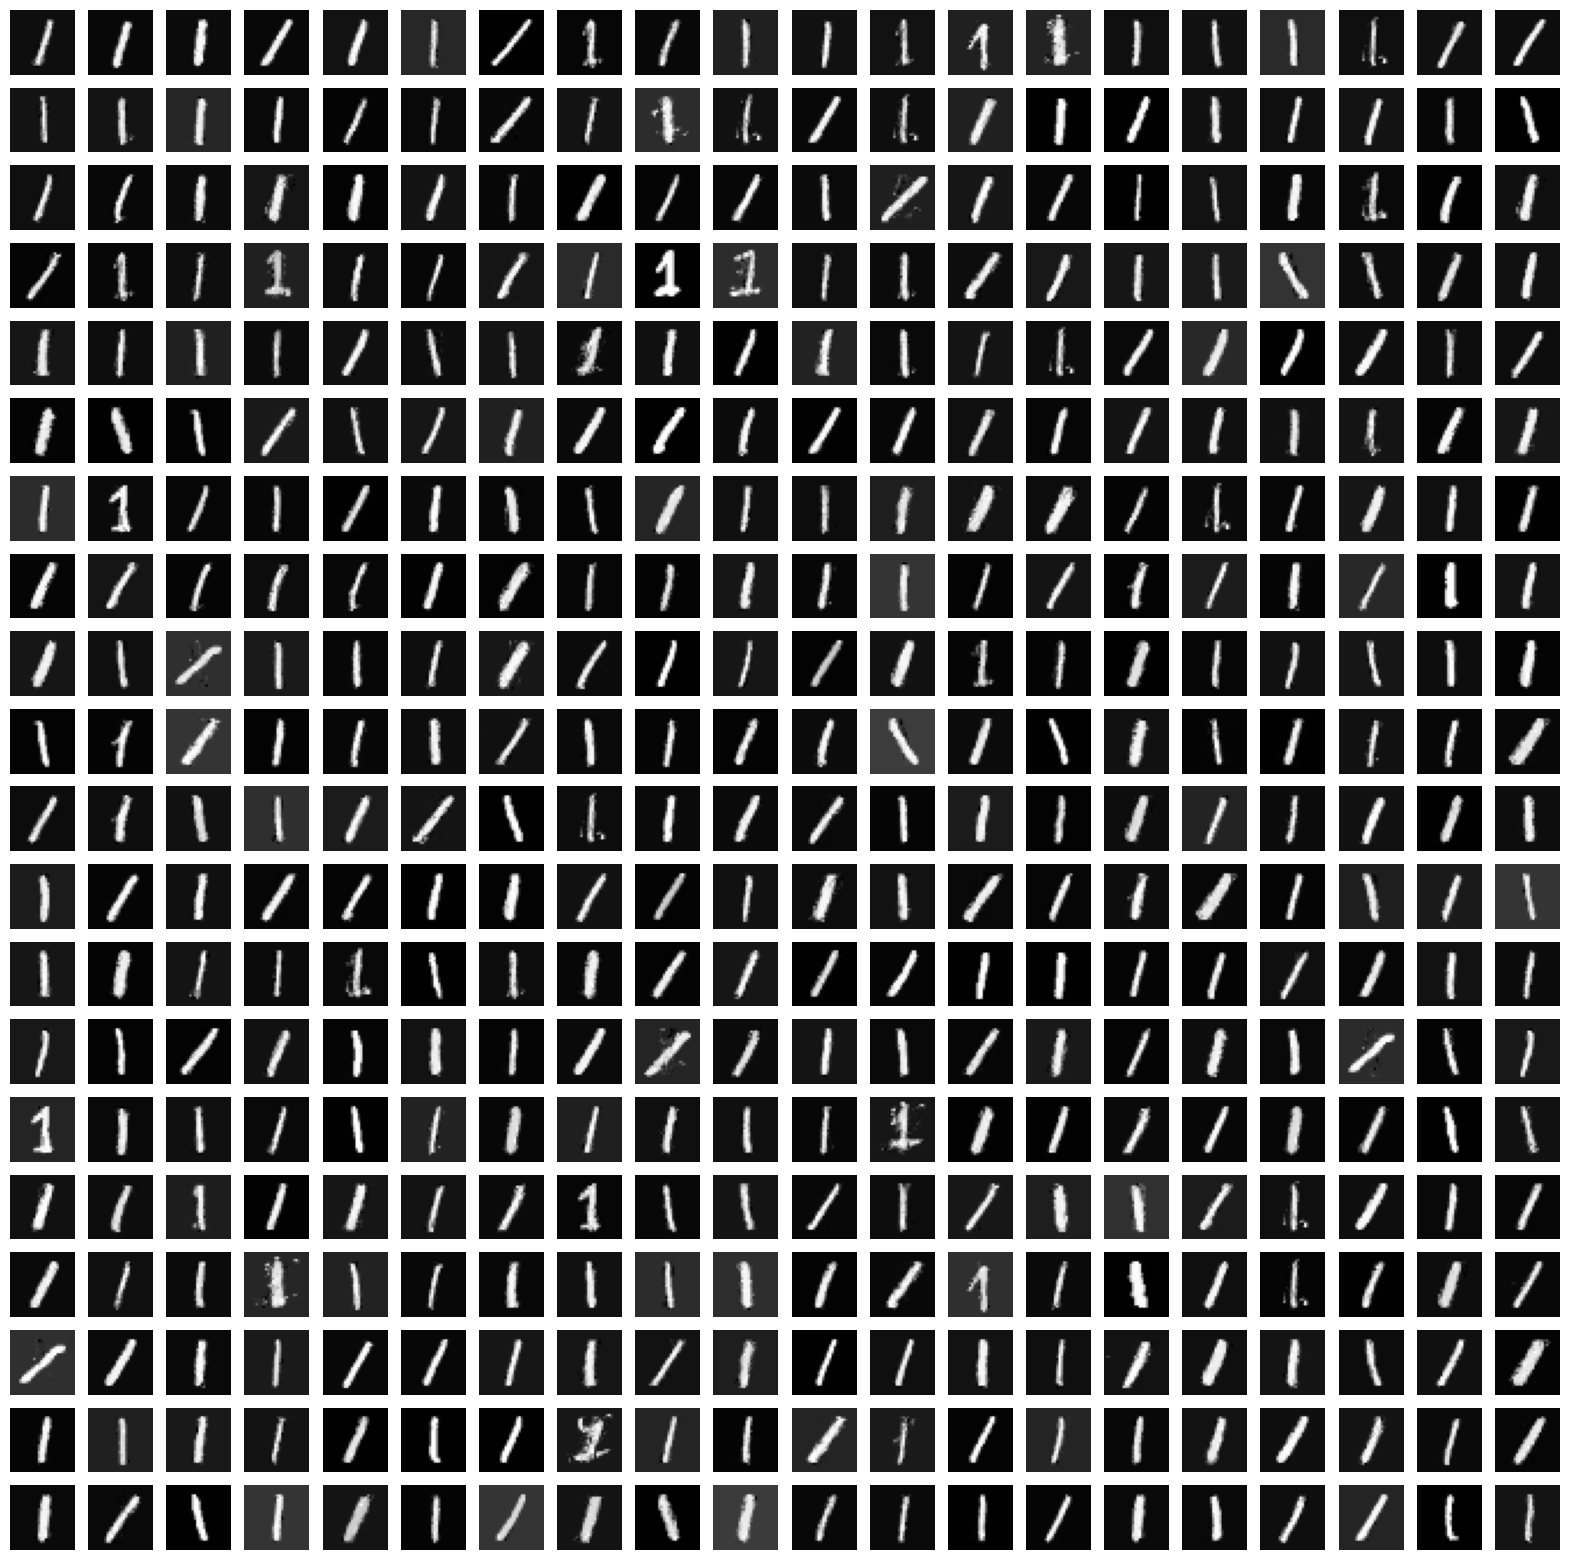

In [ ]:
plot_generated_images(generated_images)